In [ ]:
%pip install pandas
%pip install scikit-learn
%pip install xgboost


In [1]:
import pandas as pd
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [26]:
SO2_ts_df = pd.read_csv(r"..\data\API Recreate\pred\csv\SO2_TS_pred.csv")
NO2_ts_df = pd.read_csv(r"..\data\API Recreate\pred\csv\NO2_TS_pred.csv")
CO_ts_df = pd.read_csv(r"..\data\API Recreate\pred\csv\CO_TS_pred.csv")
PM25_ts_df = pd.read_csv(r"..\data\API Recreate\pred\csv\PM25_TS_pred.csv")

In [27]:
Indian_cities = pd.read_excel(r'..\data\India_cities_1.xlsx')
cities = list(Indian_cities['CITY'])
cities

['Delhi',
 'Mumbai',
 'Hyderabad',
 'Bengaluru',
 'Chennai',
 'Pune',
 'Kolkata',
 'Agra',
 'Lucknow',
 'Patna',
 'Faridabad',
 'Varanasi',
 'Chandigarh',
 'Ghaziabad',
 'Kanpur',
 'Meerut',
 'Moradabad',
 'Agartala',
 'Aurangabad',
 'Bareilly',
 'Gandhinagar',
 'Gwalior',
 'Imphal',
 'Jaipur',
 'Prayagraj',
 'Shillong',
 'Thiruvananthapuram',
 'Aizwal',
 'Amritsar',
 'Asansol',
 'Belgaum',
 'Bhopal',
 'Coimbatore',
 'Dehradun',
 'Bhilai',
 'Gangtok',
 'Gorakhpur',
 'Indore',
 'Jabalpur',
 'Jalandhar',
 'Jodhpur',
 'Kochi',
 'Kohima',
 'Kota',
 'Kozhikode',
 'Ludhiana',
 'Mangalore',
 'Mysuru',
 'Nashik',
 'Puducherry',
 'Solapur',
 'Srinagar',
 'Vijaywada',
 'Visakhapatnam']

In [81]:
unemploy_dir = r"..\data\Unemployment_Rate_IN"
open_API_dir = r"..\data\Data_Openweathermap\raw_data\\"
sav_RandomForest =r"..\data\Predicted_unemployment_daily\Random_Forest\\"
sav_XGBoost =r"..\data\Predicted_unemployment_daily\XGBoost\\"
sav_LinearRegression =r"..\data\Predicted_unemployment_daily\Linear_Regression\\"
sav_ElasticNet =r"..\data\Predicted_unemployment_daily\Elastic_Net\\"
scoredf = pd.DataFrame(columns=['City', 'RandomForestRegressor','Linear Regression','XGBRegressor','ElasticNet'])
cv_scoredf = pd.DataFrame(columns=['City', 'RandomForestRegressor','Linear Regression','XGBRegressor','ElasticNet'])

In [82]:
from sklearn.model_selection import cross_val_score

missing = []
for city in cities:
    flag = 0
    for filename in os.listdir(unemploy_dir):
        if city in filename:
            # print(filename)
            flag = 1
            eco_df = pd.read_csv(unemploy_dir + "\\" + filename)[['Region','Date',' Estimated Unemployment Rate (%)']]
    if flag == 0:
        missing.append(city)
    else:
        if city != "Bhilai":
            eco_df.index = pd.to_datetime(eco_df['Date']).dt.to_period('M')
            cur_eco_df = eco_df[eco_df['Region']==city]
            cur_eco_df_daily=cur_eco_df.resample('D').ffill().drop(columns=['Date'])

            cur_SO2 = SO2_ts_df[city + '_SO2']
            cur_SO2.index = pd.to_datetime(SO2_ts_df['date']).dt.to_period('D')
            cur_SO2 = cur_SO2.sort_index(ascending=True)

            cur_NO2 = NO2_ts_df[city + '_NO2']
            cur_NO2.index = pd.to_datetime(NO2_ts_df['date']).dt.to_period('D')
            cur_NO2 = cur_NO2.sort_index(ascending=True)

            cur_CO = CO_ts_df[city + '_CO']
            cur_CO.index = pd.to_datetime(CO_ts_df['date']).dt.to_period('D')
            cur_CO = cur_CO.sort_index(ascending=True)

            cur_PM25 = PM25_ts_df[city + '_PM25']
            cur_PM25.index = pd.to_datetime(PM25_ts_df['date']).dt.to_period('D')
            cur_PM25 = cur_PM25.sort_index(ascending=True)

            cur_SO2 = cur_SO2['2018-01-08':]
            cur_NO2 = cur_NO2['2018-01-08':]
            cur_CO = cur_CO['2018-01-08':]
            cur_PM25 = cur_PM25['2018-01-08':]

            cur_df_former = pd.DataFrame({'CO':cur_CO,'NO2':cur_NO2,'SO2':cur_SO2,'PM2_5':cur_PM25})

            cur_df_last = pd.read_csv(open_API_dir + city + "_raw.csv",index_col=0)
            cur_df_last.index = pd.to_datetime(cur_df_last['Date']).dt.to_period('D')
            cur_df_last = cur_df_last['2022-01-01':][['CO','NO2','SO2','PM2_5']]

            cur_df = pd.concat([cur_df_former, cur_df_last])

            cur_df['UnemployedRate'] = cur_eco_df_daily['2018-01-07':'2022-07-25'][' Estimated Unemployment Rate (%)']
            cur_df = cur_df.fillna(method='ffill')

            cur_df_new = cur_df.rolling(7, min_periods=1).mean()

            cur_df_new = scaler.fit_transform(cur_df_new[['CO','NO2','SO2','PM2_5']])
            # cur_df_new = cur_df_new.append(cur_df['UnemployedRate']).reshape(len(cur_df),5)
            cur_df_new = pd.DataFrame(cur_df_new, index=cur_df.index, columns=cur_df.columns[:4])
            # print(cur_df_new.columns)
            cur_df_new['UnemployedRate'] = cur_df['UnemployedRate']

            # display(cur_df_new)

            X = cur_df_new[['CO','NO2','SO2','PM2_5']]
            y = cur_df_new['UnemployedRate']
            X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=0)

            try:
                regr = RandomForestRegressor(n_estimators=10, random_state=0)
                regr.fit(X_train, y_train)
                regr_score = regr.score(X_test, y_test)
                
                
                cv_regr_scores = cross_val_score(regr, X_train, y_train, cv=10)
                
                reg = LinearRegression().fit(X_train, y_train)
                reg_score = reg.score(X_test, y_test)

                cv_reg_scores = cross_val_score(reg, X_train, y_train, cv=10)
                
                xgb = XGBRegressor()
                xgb.fit(X_train, y_train)
                xgb_score = xgb.score(X_test, y_test)

                cv_xgb_scores = cross_val_score(xgb, X_train, y_train, cv=10)
                
                en = ElasticNet()
                en.fit(X_train, y_train)
                en_score = en.score(X_test, y_test)

                cv_en_scores = cross_val_score(en, X_train, y_train, cv=10)

                cur_score = [city, regr_score, reg_score, xgb_score,en_score]
                cv_scores = [city, cv_regr_scores, cv_reg_scores, cv_xgb_scores,cv_en_scores]
                scoredf.loc[len(scoredf)] = cur_score
                cv_scoredf.loc[len(cv_scoredf)] = cv_scores

                result1 = X_test.copy()
                result1['Predicted_Unemployment_Rate'] = regr.predict(X_test)
                result1 = result1.sort_index()
                result1 = result1.reset_index()
                result1.rename(columns = {'index':'Date'},inplace=True)
                ground_truth = y_test.sort_index()
                result1['ground_truth'] = ground_truth.values
                result1.to_csv(sav_RandomForest + city + ".csv")

                result2 = X_test.copy()
                result2['Predicted_Unemployment_Rate'] = xgb.predict(X_test)
                result2 = result2.sort_index()
                result2 = result2.reset_index()
                result2.rename(columns = {'index':'Date'},inplace=True)
                ground_truth = y_test.sort_index()
                result2['ground_truth'] = ground_truth.values
                result2.to_csv(sav_XGBoost + city + ".csv")

                result3 = X_test.copy()
                result3['Predicted_Unemployment_Rate'] = reg.predict(X_test)
                result3 = result3.sort_index()
                result3 = result3.reset_index()
                result3.rename(columns = {'index':'Date'},inplace=True)
                ground_truth = y_test.sort_index()
                result3['ground_truth'] = ground_truth.values
                result3.to_csv(sav_LinearRegression + city + ".csv")

                result4 = X_test.copy()
                result4['Predicted_Unemployment_Rate'] = en.predict(X_test)
                result4 = result4.sort_index()
                result4 = result4.reset_index()
                result4.rename(columns = {'index':'Date'},inplace=True)
                ground_truth = y_test.sort_index()
                result4['ground_truth'] = ground_truth.values
                result4.to_csv(sav_ElasticNet + city + ".csv")
            except:
                print(city)

Gangtok


In [30]:
missing

['Varanasi', 'Thiruvananthapuram', 'Vijaywada', 'Visakhapatnam']

In [31]:
scoredf.to_csv(r"..\data\Predicted_unemployment_daily\scores.csv")
cv_scoredf.to_csv(r"..\data\Predicted_unemployment_daily\cv_scores.csv")

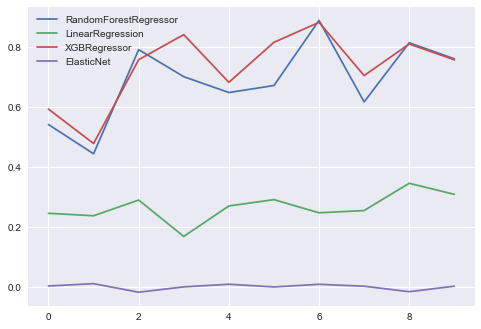

In [93]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.lineplot(x = range(len(cv_scoredf[cv_scoredf["City"]=="Delhi"].RandomForestRegressor[0])),y = cv_scoredf[cv_scoredf["City"]=="Delhi"].RandomForestRegressor[0])
# plt.savefig(r"C:\Users\12600\Desktop\rfcv.png")

sns.lineplot(x = range(len(cv_scoredf[cv_scoredf["City"]=="Delhi"]["Linear Regression"][0])),y = cv_scoredf[cv_scoredf["City"]=="Delhi"]["Linear Regression"][0])
# plt.savefig(r"C:\Users\12600\Desktop\lrcv.png")

sns.lineplot(x = range(len(cv_scoredf[cv_scoredf["City"]=="Delhi"].XGBRegressor[0])),y = cv_scoredf[cv_scoredf["City"]=="Delhi"].XGBRegressor[0])
# plt.savefig(r"C:\Users\12600\Desktop\xgbcv.png")

sns.lineplot(x = range(len(cv_scoredf[cv_scoredf["City"]=="Delhi"].ElasticNet[0])),y = cv_scoredf[cv_scoredf["City"]=="Delhi"].ElasticNet[0])
plt.legend(['RandomForestRegressor','LinearRegression','XGBRegressor','ElasticNet'],loc = 'upper left')
plt.savefig(r"..\data\Predicted_unemployment_daily\cv_scores.jpg")


In [3]:
uninDe = pd.read_csv(r"..\data\Unemployment_Rate_IN\unemployment_IN_Delhi.csv")
input = uninDe[' Estimated Unemployment Rate (%)']
input
uninDe

Region      Date  Frequency   Estimated Unemployment Rate (%)  \
0   Delhi  01-31-16          M                             10.61   
1   Delhi  02-29-16          M                             10.84   
2   Delhi  03-31-16          M                             11.05   
3   Delhi  04-30-16          M                              6.30   
4   Delhi  05-31-16          M                             17.30   
..    ...       ...        ...                               ...   
74  Delhi  03-31-22          M                              8.86   
75  Delhi  04-30-22          M                             11.18   
76  Delhi  05-31-22          M                             13.64   
77  Delhi  06-30-22          M                             10.28   
78  Delhi  07-31-22          M                              8.92   

     Estimated Employed   Estimated Labour Participation Rate (%)  
0               5482637                                     44.00  
1               4829996                                     38.78  
2               5513829                                     44.26  
3               5954845                                     45.28  
4               5523948                                     47.48  
..                  ...                                       ...  
74              5171901                                     34.09  
75              5376548                                     36.28  
76              5432451                                     37.60  
77              5327114                                     35.40  
78              5215741                                     34.06  

[79 rows x 6 columns]

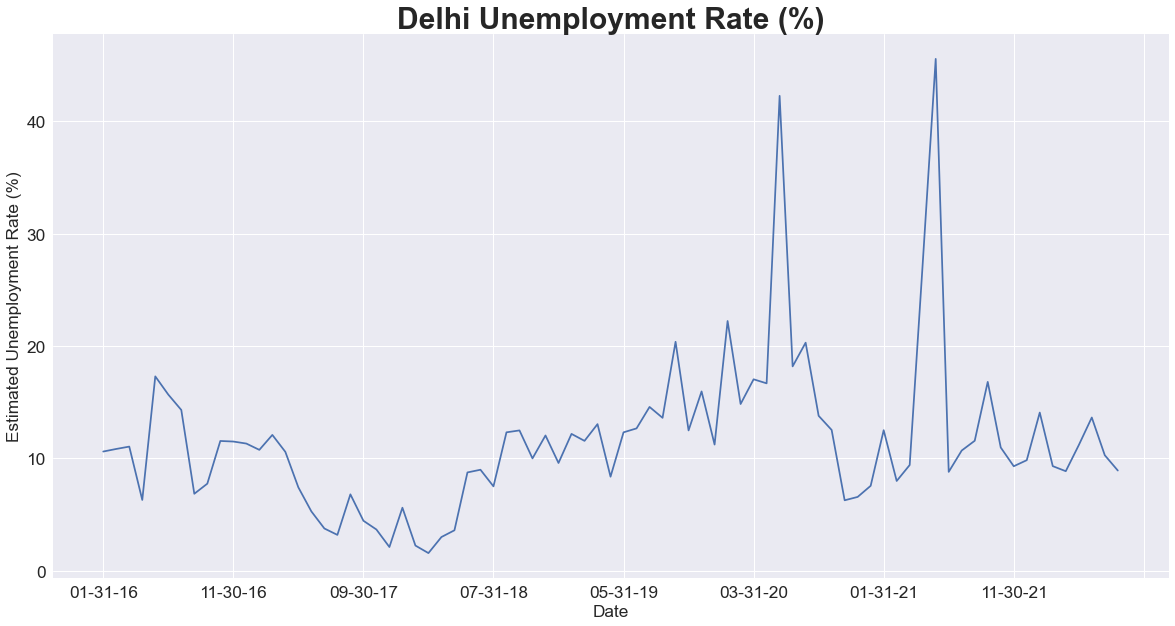

In [56]:
plt.style.use('seaborn')
ax = uninDe.plot(x = 'Date',y = ' Estimated Unemployment Rate (%)',figsize=(20, 10),legend = False)
plt.xlabel('Date',fontsize='xx-large')
plt.ylabel('Estimated Unemployment Rate (%)',fontsize='xx-large')
plt.xticks(fontsize = 'xx-large')
plt.yticks(fontsize = 'xx-large')
plt.title('Delhi Unemployment Rate (%)', fontsize = 30, fontweight = 'bold')
plt.show()